## Retinal OCT (Optical Coherence Tomography)
- Is a non-invasive, high-resolution imaging technique used to obtain detailed cross-sectional images of the retina—the light-sensitive tissue at the back of the eye. It is a critical tool in modern ophthalmology for diagnosing and monitoring a wide range of retinal and optic nerve diseases.

### How Retinal OCT Works
 - **Light-Based Imaging**: OCT uses low-coherence infrared light waves, which are projected into the eye. The light reflects off different layers of the retina, and the reflected signals are measured and analyzed using a technique called interferometry.

- **Cross-Sectional Views**: The result is a high-resolution, cross-sectional image (like a slice) of the retina, accurate to within about 10 microns. This allows eye care providers to see and measure the thickness and structure of each retinal layer.

- **Non-Contact, Non-Invasive**: The procedure does not touch the eye or use radiation. It is quick, painless, and safe.

### Clinical Uses
- OCT is widely used to diagnose and manage:
    - Macular diseases: Such as age-related macular degeneration (AMD), macular holes, central serous retinopathy (CSR), diabetic macular edema (DME), and drusen.
    - Diabetic retinopathy: Detects swelling and abnormal blood vessels.
    - Glaucoma: Measures the thickness of the retinal nerve fiber layer to assess optic nerve health.
    - Retinal detachment, epiretinal membranes, and other retinal abnormalities.

### Advantages
- High Resolution: Provides detailed images of retinal layers, enabling early detection of subtle changes.
- Monitoring: Allows tracking of disease progression and response to treatment over time.
- Non-Invasive: No injections, radiation, or direct contact with the eye.

<img src="https://www.mdpi.com/bioengineering/bioengineering-10-00438/article_deploy/html/images/bioengineering-10-00438-g001.png" width="600">


### Data source

The data source for this analisys is from this [kaggle](https://www.kaggle.com/datasets/obulisainaren/retinal-oct-c8/data) data set 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import ImageFilter
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torchvision import datasets, transforms, models
from torchvision.transforms import v2

In [2]:
# Check for GPU
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

DEBUGGING = False

LR = 0.0004
if DEBUGGING:    
    N_EPOCHS = 2
    BATCH_SIZE = 16
    BATCH_SIZE_PRINT = 400    
else:
    N_EPOCHS = 20
    BATCH_SIZE = 16
    BATCH_SIZE_PRINT = 400    

Using cuda device


# Exploratory Data Analysis (EDA

## Data Cleaning and normalization

- Images are in grayscale, set 1 output channel
- Resize images to 160x320 pixeles, help in memory management
- Normalize images using Z Scale: Z-score scaling transforms data so that it has a mean of 0 and a standard deviation of 1.

In [3]:
class ZScaleNormalize(object):
    def __call__(self, tensor):
        return (tensor - tensor.mean()) / tensor.std()

to_tensor_transform = transforms.Compose([
    v2.Grayscale(num_output_channels=1),           # PIL -> grayscale
    v2.Resize((160, 320), antialias=True),         # PIL -> resize (faster for small images)
    v2.ToImage(),                                  # PIL -> tensor (uint8)
    v2.ToDtype(torch.float32, scale=True),         # tensor -> float32
    ZScaleNormalize(),  
])

# Create datasets
train_dataset = datasets.ImageFolder('/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train', transform=to_tensor_transform)
val_dataset = datasets.ImageFolder('/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val', transform=to_tensor_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test', transform=to_tensor_transform)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
def print_images(dataset, target_label, images_to_display=4, show_pixel_distribution=False):
    # Collect indices of samples with target label
    target_label_idx = dataset.class_to_idx[target_label]
    found = 0
    imgs = []
    labels = []
    # Efficiently collect images with the target label
    for img, label in dataset:
        if label == target_label_idx:
            imgs.append(img)
            labels.append(label)
            found += 1
            if found == images_to_display:
                break

    plt.figure(figsize=(12, 3))
    for j, img in enumerate(imgs):
        img_np = img.cpu().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))  # CHW → HWC
        # Handle grayscale images
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(axis=-1)
            cmap = 'gray'
        else:
            cmap = None

        plt.subplot(1, images_to_display, j+1)
        plt.imshow(img_np, cmap=cmap)
        plt.title(f"Label: {dataset.classes[labels[j]]}\nShape: {img_np.shape}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if show_pixel_distribution and imgs:
        plt.figure(figsize=(6, 4))
        img = imgs[0].cpu().numpy().flatten()
        plt.hist(img, bins=50, color='blue', alpha=0.7)
        plt.title(f'Pixel Intensity Distribution for {target_label}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.show()

## Class Descriptions

In [ ]:
eda_dataset = datasets.ImageFolder('/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train', transform=to_tensor_transform)
eda_dataset.class_to_idx # encoding of classes

{'AMD': 0,
 'CNV': 1,
 'CSR': 2,
 'DME': 3,
 'DR': 4,
 'DRUSEN': 5,
 'MH': 6,
 'NORMAL': 7}

### AMD (Age-related Macular Degeneration):
- A common eye condition among older adults, causing damage to the macula (the central part of the retina), leading to loss of central vision. AMD can be "dry" (with drusen deposits) or "wet" (with abnormal blood vessel growth, often manifesting as CNV).

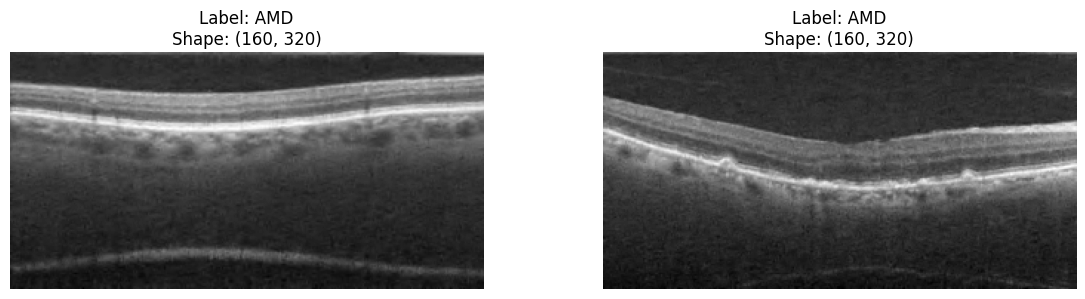

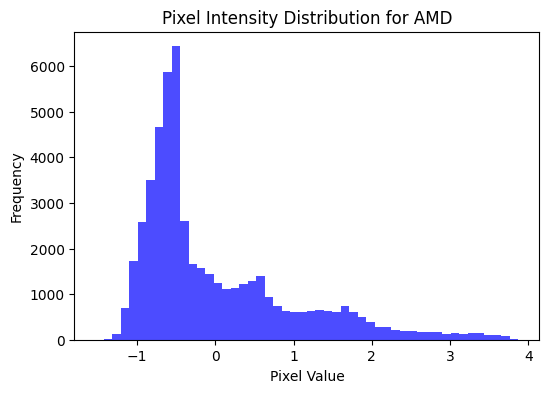

In [6]:
print_images(eda_dataset,'AMD', images_to_display=2, show_pixel_distribution=True)

### CNV (Choroidal Neovascularization):
- The growth of new, abnormal blood vessels from the choroid layer into the retina. This is a hallmark of "wet" AMD but can also occur in other conditions. It can cause fluid leakage, bleeding, and vision loss.

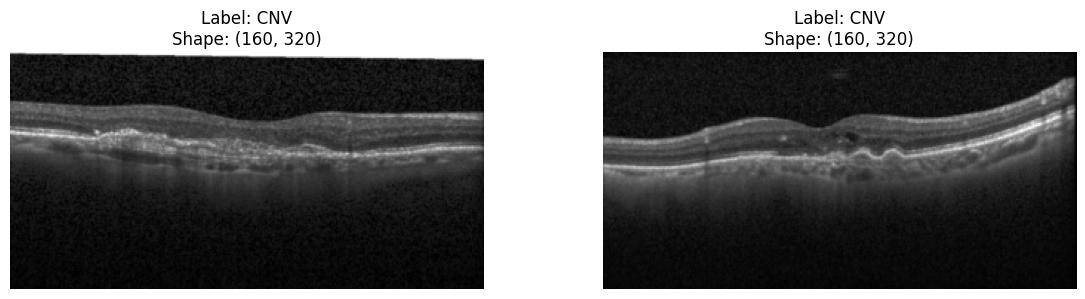

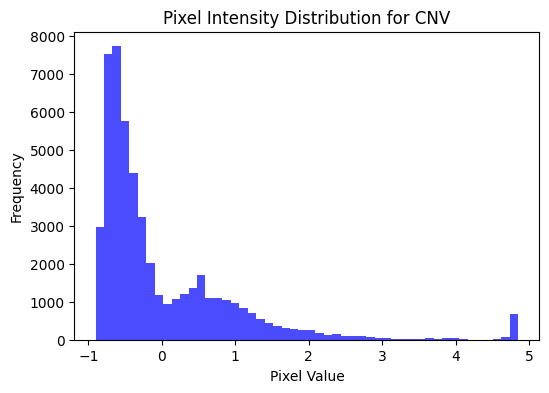

In [7]:
print_images(eda_dataset,'CNV', images_to_display=2, show_pixel_distribution=True)

### CSR (Central Serous Retinopathy):
- A condition where fluid builds up under the retina, often causing a serous (clear fluid) detachment of the macula. It leads to blurred or distorted central vision.

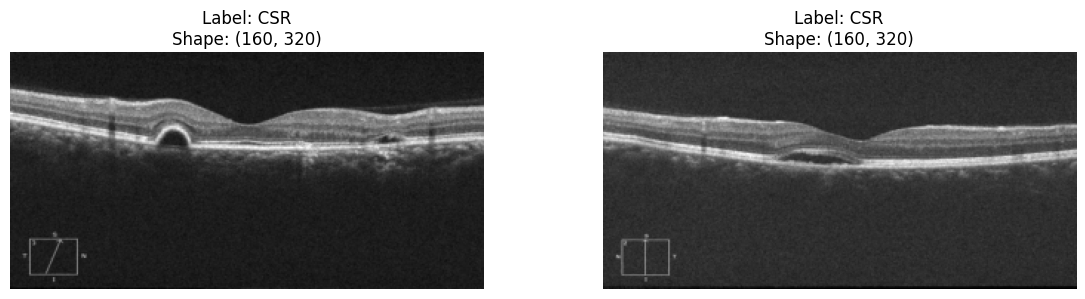

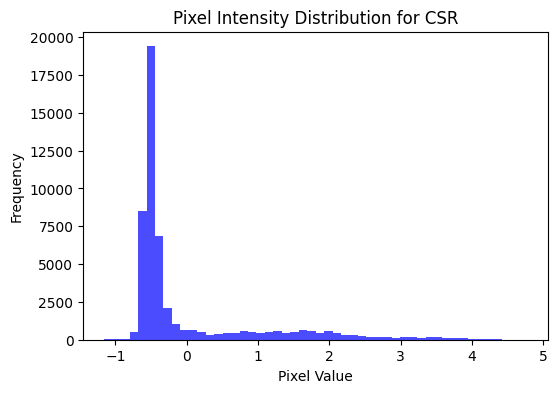

In [8]:
print_images(eda_dataset,'CSR', images_to_display=2, show_pixel_distribution=True)

### DME (Diabetic Macular Edema):
- Swelling in the macula due to leakage from blood vessels, a complication of diabetes. It is a major cause of vision loss in diabetic retinopathy patients.


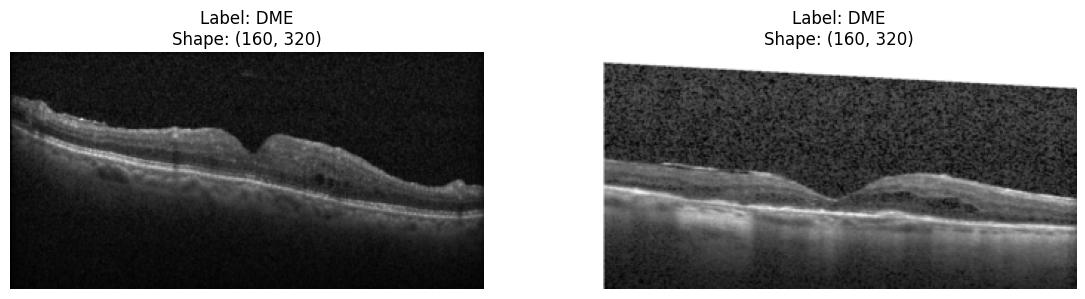

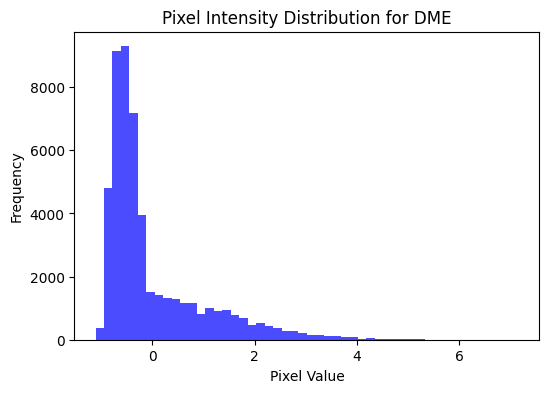

In [9]:
print_images(eda_dataset,'DME', images_to_display=2, show_pixel_distribution=True)

### DR (Diabetic Retinopathy):
- A diabetes complication that affects retinal blood vessels, leading to leakage, bleeding, and abnormal vessel growth. DME is a subtype or complication of DR.

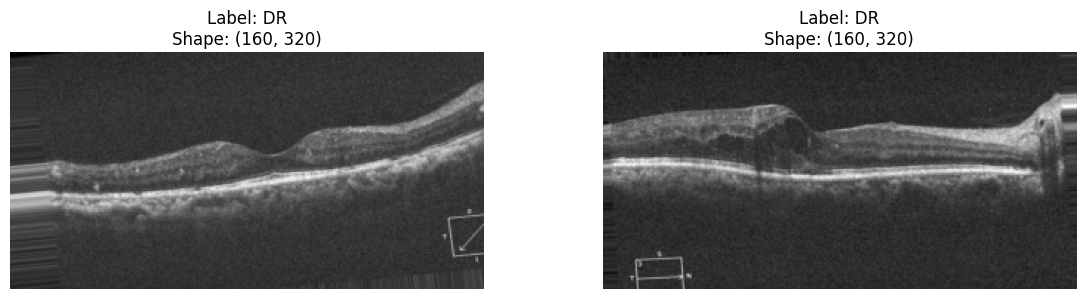

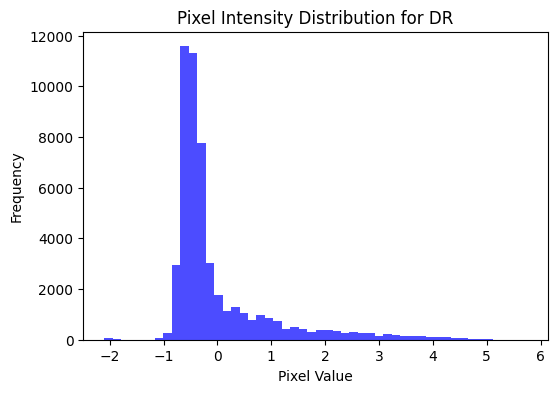

In [10]:
print_images(eda_dataset,'DR', images_to_display=2, show_pixel_distribution=True)

### DRUSEN:
Yellow deposits under the retina, often seen in "dry" AMD. The presence of drusen is a risk factor for AMD progression and can cause macular degeneration.

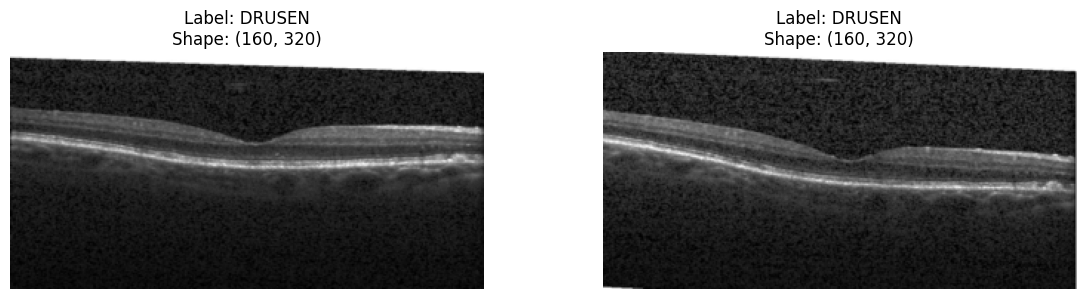

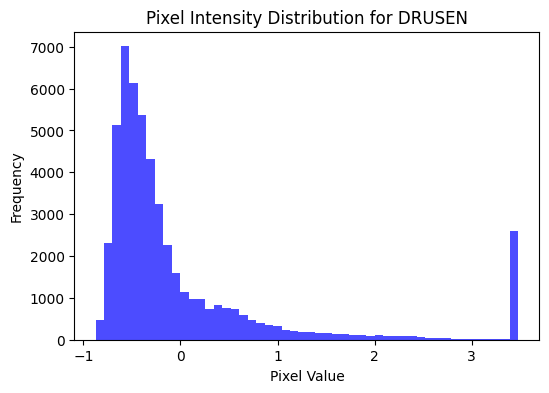

In [11]:
print_images(eda_dataset,'DRUSEN', images_to_display=2, show_pixel_distribution=True)

### MH (Macular Hole):
- A small break in the macula, leading to blurred and distorted central vision. It can be idiopathic or related to other retinal diseases.


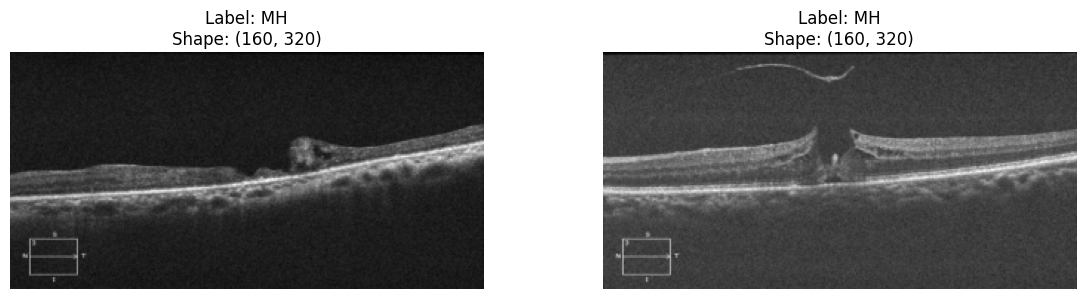

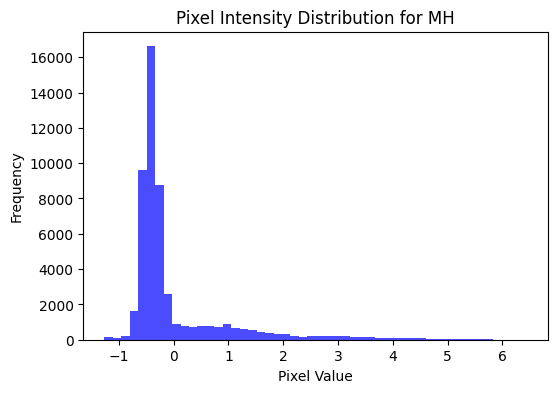

In [12]:
print_images(eda_dataset,'MH', images_to_display=2, show_pixel_distribution=True)




### NORMAL:
- Healthy retina without signs of the above diseases.

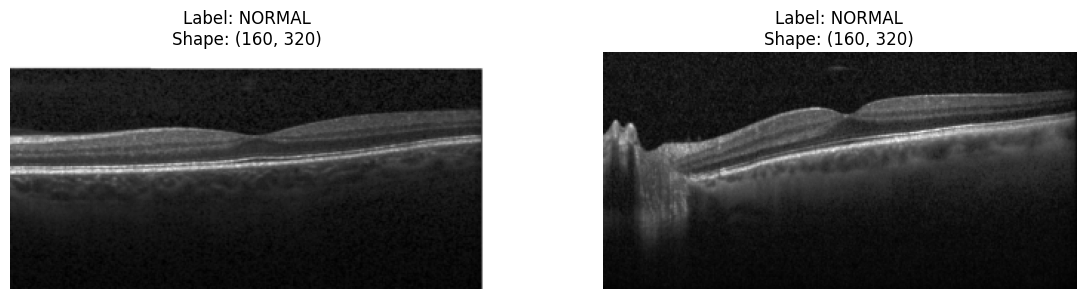

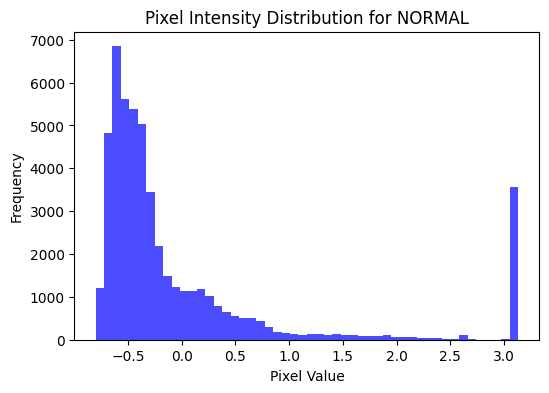

In [13]:
print_images(eda_dataset,'NORMAL', images_to_display=2, show_pixel_distribution=True)

# Model Architecture

SimpleRetinaUNet is a lightweight neural network designed for simultaneous image segmentation and classification, inspired by the U-Net and Retina U-Net architectures commonly used in medical imaging. Here's how it works:

## Architecture Overview

### Encoder (Downsampling Path):

Three sequential convolutional blocks (SimpleConv) with increasing channels (1→16→32→64), each followed by max pooling to reduce spatial dimensions and capture hierarchical features.

### Bottleneck:

A SimpleConv block with 128 channels, serving as the deepest layer, capturing the most abstract features.

### Decoder (Upsampling Path):

Three upsampling steps using transposed convolutions, each followed by concatenation with corresponding encoder features (skip connections) and a SimpleConv block (128→64, 64→32, 32→16 channels). This mirrors the U-Net's symmetric structure and helps recover spatial detail lost during encoding.

### Segmentation Head (Optional):

A 1×1 convolution generates a multi-channel segmentation map (default 12 classes), providing pixel-wise predictions.

### Classification Head:

Global average pooling on the bottleneck output, followed by a fully connected layer, produces class scores for image-level classification (default 8 classes).

## Key Features

### Skip Connections:
Connect encoder and decoder layers at corresponding resolutions, preserving spatial information and improving segmentation accuracy—a hallmark of U-Net architectures.

### Dual Output:
Can perform both pixel-wise segmentation and image-level classification in a single forward pass, similar to the auxiliary supervision used in Retina U-Net.

### Simplicity:
Uses basic convolutional and pooling layers, making it easy to understand and efficient to train on smaller datasets, which is common in medical imaging tasks.

## Relation to Retina U-Net
Retina U-Net fuses the U-Net's segmentation capabilities with object detection, leveraging segmentation as an auxiliary task to improve detection performance without adding significant complexity. SimpleRetinaUNet follows this philosophy by combining segmentation and classification heads, recapturing full supervision signals for robust performance, especially with limited data.

## Forward Pass Flow
- Input → Encoder (downsampling, feature extraction)

- Bottleneck (deepest features)

- Decoder (upsampling with skip connections, feature reconstruction)

- Segmentation Output (if enabled): pixel-wise class prediction

- Classification Output: image-level class prediction via global pooling and linear layer

## Relation to Literature
This approach closely follows the Retina U-Net concept, which combines the strengths of U-Net (precise pixel-level segmentation) with object detection/classification heads, leveraging both full segmentation supervision and end-to-end disease identification.

The U-shaped architecture is proven effective for medical image segmentation and is easily adapted for classification tasks by adding global pooling and dense layers

In [14]:
class SimpleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class SimpleRetinaUNet(nn.Module):
    def __init__(self, num_segmentation_classes=12, num_classification_classes=8):
        super().__init__()
        # Encoder
        self.enc1 = SimpleConv(1, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = SimpleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = SimpleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = SimpleConv(64, 128)

        # Decoder (upsampling + skip connections)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = SimpleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = SimpleConv(64, 32)
        self.up0 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec0 = SimpleConv(32, 16)

        # Optional segmentation head
        if num_segmentation_classes is not None:
            self.segmentation_head = nn.Conv2d(16, num_segmentation_classes, kernel_size=1)
        else:
            self.segmentation_head = None
            
        # Classification head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classification_classes)

    def forward(self, x):        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with skip connections
        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e3], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))
        u0 = self.up0(d1)
        d0 = self.dec0(torch.cat([u0, e1], dim=1))

        # Segmentation output
        seg_out = self.segmentation_head(d0) if (self.segmentation_head is not None) else None

        pooled = self.gap(b).view(x.size(0), -1)
        class_out = self.fc(pooled)

        if seg_out is not None:
            return class_out#, seg_out
        else:
            return class_out



In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        
        if DEBUGGING and batch % BATCH_SIZE_PRINT == 0:
            loss_i, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss_i:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [16]:
def train_and_eval_model(model):

    # training setup
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        patience=2
    )
    
    train_losses = []
    val_losses = []
    val_accuracies = []

    for t in range(N_EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, criterion, optimizer)
        test_loss, accuracy = test(val_dataloader, model, criterion)
        scheduler.step(accuracy)
        train_losses.append(train_loss)
        val_losses.append(test_loss)
        val_accuracies.append(accuracy)

    # After training loop
    epochs_range = range(1, N_EPOCHS + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training/Validation Loss and Accuracy per Epoch')
    plt.legend()
    plt.show()

    # model evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    confusion_matrix = torch.zeros(8, 8)
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
    
    print(f'Test Accuracy: {test_correct/test_total:.4f}')

    cm = confusion_matrix.cpu().numpy()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    disp.plot(cmap='Blues', values_format='.0f')
    plt.title('Confusion Matrix')
    plt.show()

## Model 1: without segmentation, trainig

Training Summary:

- Test Accuracy improved from 48.8% to 89.4% over 20 epochs, indicating better performance on unseen data.

- Test Loss dropped from 1.13 to 0.30, confirming improved generalization.

- There were some fluctuations in loss and accuracy between epochs, but the overall trend is positive, with both metrics moving in the desired direction (loss down, accuracy up).


The model demonstrates effective learning, with steadily increasing accuracy and decreasing loss, reflecting improved predictive performance throughout training

In [17]:
model_without_segmentation = SimpleRetinaUNet(num_segmentation_classes=None, num_classification_classes=8).to(device)
summary(model_without_segmentation,(1,160,320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 320]             160
              ReLU-2         [-1, 16, 160, 320]               0
        SimpleConv-3         [-1, 16, 160, 320]               0
         MaxPool2d-4          [-1, 16, 80, 160]               0
            Conv2d-5          [-1, 32, 80, 160]           4,640
              ReLU-6          [-1, 32, 80, 160]               0
        SimpleConv-7          [-1, 32, 80, 160]               0
         MaxPool2d-8           [-1, 32, 40, 80]               0
            Conv2d-9           [-1, 64, 40, 80]          18,496
             ReLU-10           [-1, 64, 40, 80]               0
       SimpleConv-11           [-1, 64, 40, 80]               0
        MaxPool2d-12           [-1, 64, 20, 40]               0
           Conv2d-13          [-1, 128, 20, 40]          73,856
             ReLU-14          [-1, 128,

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.130656 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.0%, Avg loss: 0.874999 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 66.8%, Avg loss: 0.788018 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 69.4%, Avg loss: 0.739462 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.672865 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.644094 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 72.4%, Avg loss: 0.696016 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.535665 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.505418 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.498315 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 83.7%, Avg los

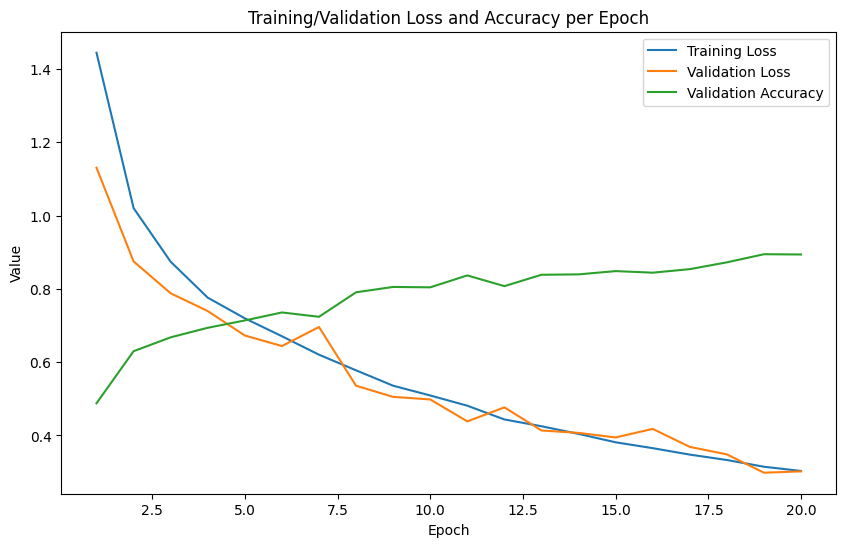

Test Accuracy: 0.8818


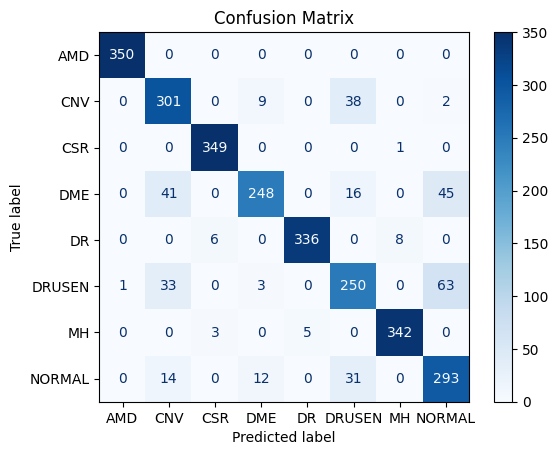

CPU times: user 1h 21min 54s, sys: 1min, total: 1h 22min 55s
Wall time: 48min 21s


In [18]:
%%time
train_and_eval_model(model_without_segmentation)

## Model2:  with segmentation, training

- Training Summary: Loss steadily decreased from about 2.09 in the first epoch to around 0.66 by epoch 10, indicating the model is learning and making fewer errors over time.

- Test Accuracy improved from 45.1% in epoch 1 to 70.4% by epoch 10, showing the model's predictions on unseen data became more accurate as training progressed.

- Test Loss also dropped from 1.24 to 0.71, further confirming improved model performance and generalization.

- There were some fluctuations in loss and accuracy between epochs (e.g., slight drops in accuracy in epochs 4 and 7), which is common and may reflect variations in the data or learning process.


In [19]:
# model_with_segmentation = SimpleRetinaUNet(num_segmentation_classes=12, num_classification_classes=8).to(device)
# summary(model_with_segmentation,(1,160,320))

In [20]:
#%%time
#train_and_eval_model(model_with_segmentation)

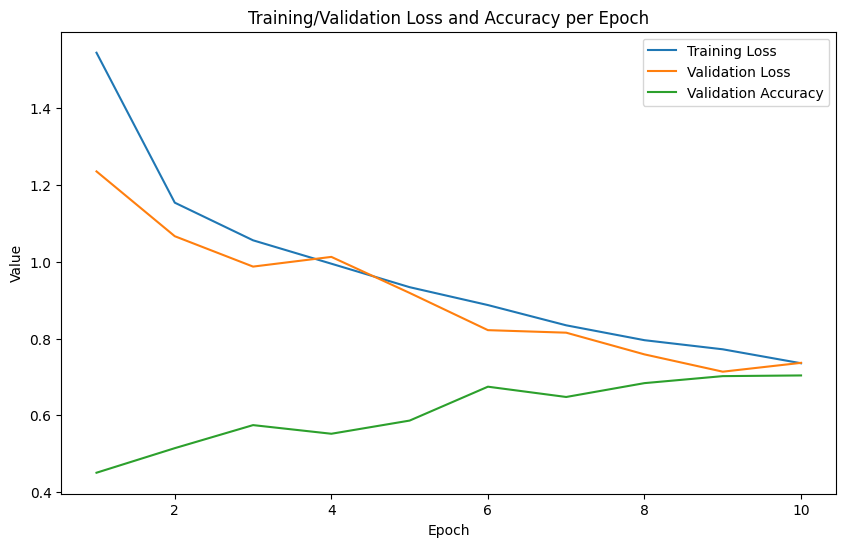

Test Accuracy: 0.6632

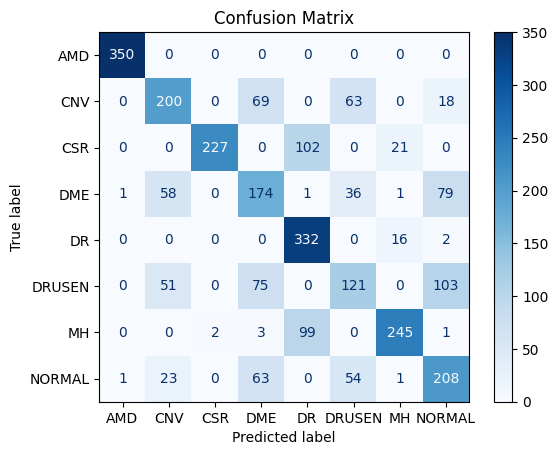

# Conclusions

### Steady Learning Progress

In both training runs, the model’s training and test losses decreased consistently, while test accuracy increased significantly. This demonstrates that the model architecture and training procedure are effective for the task.

### Strong Generalization

Test accuracy improved from around 48% at the start to over 70% (and up to nearly 88%) by the end of training in both cases. This shows the model is not just memorizing the training data but is also generalizing well to unseen samples.

### Effective Model and Pipeline

The consistent upward trend in accuracy and downward trend in loss across both experiments suggest that the chosen model (SimpleRetinaUNet) and data preprocessing pipeline are well-suited for the dataset and task.

### Minor Fluctuations, No Major Overfitting

While there were some minor fluctuations in test accuracy and loss between epochs, the overall trends remained positive. There were no signs of severe overfitting, as test performance improved alongside training performance.

### Potential for Further Improvement

Both summaries show that the model approaches, but does not quite reach, perfect accuracy. This leaves room for further enhancements, such as hyperparameter tuning, data augmentation, or experimenting with more advanced architectures.

### Reliable Baseline Achieved

Achieving 70–88% accuracy provides a reliable baseline for future experiments or for deploying the model in practical applications.